/var/folders/sb/sj92n15179xflbsf3hhfy7cw0000gn/T/ipykernel_5243/3527087648.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='finding_class', y='num_images', data=class_counts_normal, palette=bar_colors_normal.to_list(), ax=ax1)
/var/folders/sb/sj92n15179xflbsf3hhfy7cw0000gn/T/ipykernel_5243/3527087648.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='finding_class', y='num_images', data=class_counts_filtered, palette=bar_colors_filtered.to_list(), ax=ax2)


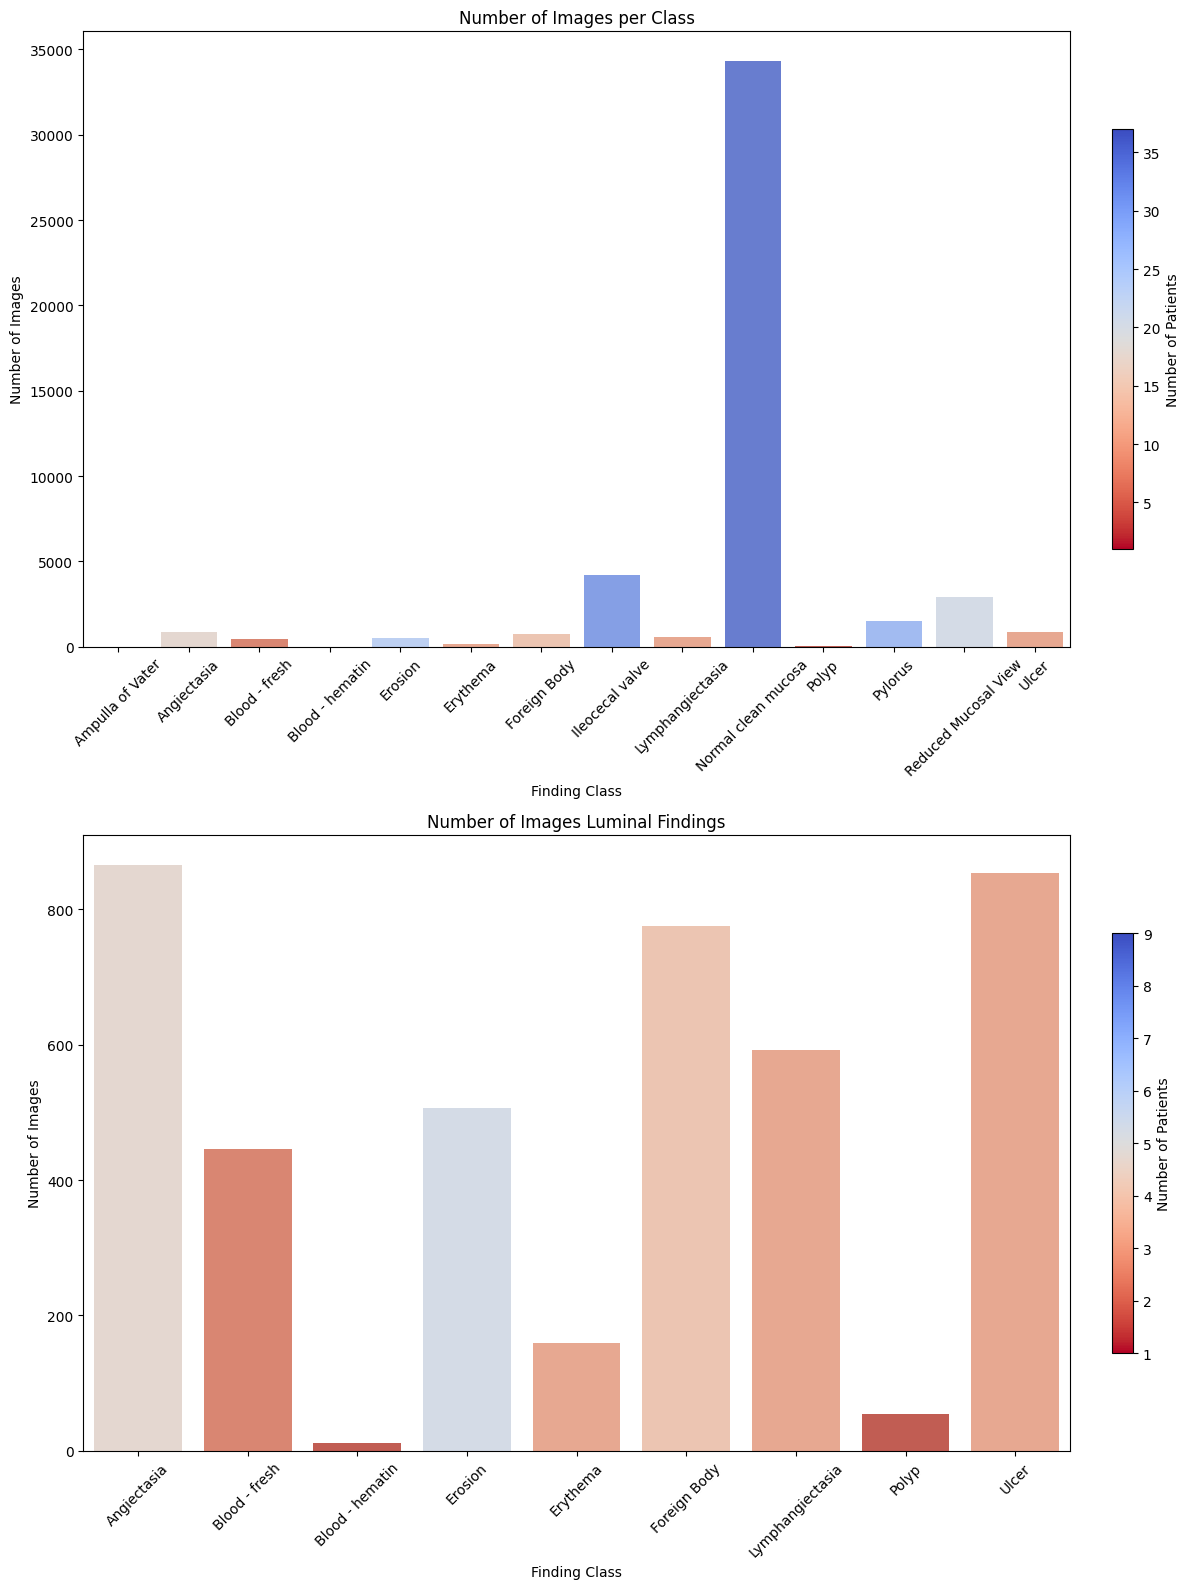

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '../data/kvasir_capsule/metadata.csv'
metadata = pd.read_csv(file_path, delimiter=';')
# Create the filtered metadata
filtered_metadata = metadata[
    (metadata['finding_class'] != 'Normal clean mucosa') &
    (metadata['finding_class'] != 'Ileocecal valve') &
    (metadata['finding_class'] != 'Pylorus') &
    (metadata['finding_class'] != 'Ampulla of Vater') &
    (metadata['finding_class'] != 'Reduced Mucosal View')
]


# Group by finding class and count the number of unique video_ids (patients) and filenames (images)
class_counts_normal = metadata.groupby('finding_class').agg(
    num_patients=('video_id', 'nunique'),
    num_images=('filename', 'count')
).reset_index()

class_counts_filtered = filtered_metadata.groupby('finding_class').agg(
    num_patients=('video_id', 'nunique'),
    num_images=('filename', 'count')
).reset_index()

# Set up the matplotlib figure and axes for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for normal metadata
colors_normal = sns.color_palette("coolwarm_r", as_cmap=False, n_colors=class_counts_normal['num_patients'].nunique())
color_mapping_normal = {count: color for count, color in zip(sorted(class_counts_normal['num_patients'].unique()), colors_normal)}
bar_colors_normal = class_counts_normal['num_patients'].map(color_mapping_normal)

sns.barplot(x='finding_class', y='num_images', data=class_counts_normal, palette=bar_colors_normal.to_list(), ax=ax1)
ax1.set_title('Number of Images per Class')
ax1.set_xlabel('Finding Class')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Add color bar for normal metadata
norm_normal = plt.Normalize(vmin=class_counts_normal['num_patients'].min(), vmax=class_counts_normal['num_patients'].max())
sm_normal = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm_normal)
sm_normal.set_array([])
cbar_normal = fig.colorbar(sm_normal, ax=ax1, orientation='vertical', fraction=0.02, pad=0.04)
cbar_normal.set_label('Number of Patients')

# Plot for filtered metadata
color_mapping_filtered = {count: color for count, color in zip(sorted(class_counts_filtered['num_patients'].unique()), colors_normal)}
bar_colors_filtered = class_counts_filtered['num_patients'].map(color_mapping_filtered)

sns.barplot(x='finding_class', y='num_images', data=class_counts_filtered, palette=bar_colors_filtered.to_list(), ax=ax2)
ax2.set_title('Number of Images Luminal Findings')
ax2.set_xlabel('Finding Class')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

# Add color bar for filtered metadata
norm_filtered = plt.Normalize(vmin=class_counts_filtered['num_patients'].min(), vmax=class_counts_filtered['num_patients'].max())
sm_filtered = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm_filtered)
sm_filtered.set_array([])
cbar_filtered = fig.colorbar(sm_filtered, ax=ax2, orientation='vertical', fraction=0.02, pad=0.04)
cbar_filtered.set_label('Number of Patients')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Order SeeAI

In [1]:
from PIL import Image
import glob
image_list = []
path = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images/*.jpg"
image_list = glob.glob(path)

### Get lesions 
There are some columns we can remove such as the "image_number" and the "annotation_class_name" column. The entries (image_numbers) are already sorted numerically, this is why we can use the index as replacement for an explicit image number colums.

The first row does not contain any valuable information, as far as I have seen. We separate the last row from the rest because it contains how many annotation per class there actually are. This is a different kind of valuable information and therefore not discarded but separated. 

In [2]:
df = pd.read_csv("../data/see_ai/all_annotation.csv")
annotaions_per_image = df.filter(["annotation_number"])[1:]
annotaions_per_class = df[-1:]
df = df.drop(columns=[df.columns[0],df.columns[1],df.columns[-1]])[1:-1] # remove first two columns + last column + first row and last row
print(df.to_string())

       angiodysplasia  erosion  stenosis  lymphangiectasia  lymph follicle  SMT  polyp-like  bleeding  diverticulum  erythema  foreign body  vein
1                   0        0         0                 0               0    0           0         0             0         0             0     0
2                   0        0         0                 0               0    0           0         0             0         0             0     0
3                   0        0         0                 0               0    0           0         0             0         0             0     0
4                   0        0         0                 0               0    0           0         0             0         0             0     0
5                   0        0         0                 0               0    0           0         0             0         0             0     0
6                   0        0         0                 0               0    0           0         0             0         

In [3]:
def transform(df : pd.DataFrame):
    """
        For all cols
            For all entries
                if non zero:
                    safe index and push into transformed
    """
    transformed_df = df.apply(
        lambda col: pd.Series(col[col != 0].index,dtype=int)
    )
    transformed_df.fillna(-1,inplace=True)
    
    return transformed_df.astype(int)
    
transformed_df = transform(df=df)
transformed_df.to_csv("dumps/annotations_ordered.csv",",", index=False)
annotaions_per_image.to_csv("dumps/annotations_per_image.csv",",", index=False)


/var/folders/sb/sj92n15179xflbsf3hhfy7cw0000gn/T/ipykernel_49477/2272262678.py:16: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  transformed_df.to_csv("dumps/annotations_ordered.csv",",", index=False)
/var/folders/sb/sj92n15179xflbsf3hhfy7cw0000gn/T/ipykernel_49477/2272262678.py:17: FutureWarning: Starting with pandas version 3.0 all arguments of to_csv except for the argument 'path_or_buf' will be keyword-only.
  annotaions_per_image.to_csv("dumps/annotations_per_image.csv",",", index=False)


In [20]:
import numpy as np
def build_file_name(img_num : int):
    prefix = "image"
    suffix = ".jpg"
    try:
        zeros = (4 - int(np.floor(np.log10(img_num)))) * "0"
    except:
        print(img_num)
    return prefix + zeros + str(img_num) + suffix        


print(np.floor(np.log10(1)))


0.0


In [23]:
import os
import shutil
df = pd.read_csv("dumps/annotations_ordered.csv")
prefix = "./dumps/see_ai_ordered"
src_dir = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images"

if not os.path.exists(prefix):
    os.makedirs(prefix)

def copy_images(col):
    name = col.name
    dest_dir = f"{prefix}/{name}"
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    for _, img in col.items():
        if img > 0:
            src_file = f"{src_dir}/{build_file_name(img)}"
            shutil.copy(src=src_file,dst=dest_dir) 
    

In [24]:
df.apply(copy_images)

angiodysplasia      None
erosion             None
stenosis            None
lymphangiectasia    None
lymph follicle      None
SMT                 None
polyp-like          None
bleeding            None
diverticulum        None
erythema            None
foreign body        None
vein                None
dtype: object

# Automatic Patient Split

In [19]:
import cv2
import torch
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import densenet121, DenseNet121_Weights


device = torch.device("mps" if torch.backends.mps.is_built() and torch.backends.mps.is_available() else "cpu")

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break;
        frames.append(frame)
    cap.release();
    return frames;

def preprocess_frame(frame):

    preprocess = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    
    return preprocess(frame)

def extract_features(frames,model):
    features = []
    with torch.no_grad():
        for frame in frames:
            input_tensor = preprocess_frame(frame)
            input_batch = input_tensor.unsqueeze(0)
            input_batch = input_batch.to(device)
            output = model(input_batch)   
            features.append(output.cpu().numpy())
    return features



In [21]:
from torchvision.models import densenet121, resnet152, DenseNet121_Weights, ResNet18_Weights,ResNet50_Weights
import numpy as np

res_net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
res_net = torch.nn.Sequential(*(list(res_net.children())[:-1]))
res_net.eval()
res_net.to(device)

video_path = '../data/kvasir_capsule/ShortNCM.mov'
frames = extract_frames(video_path)
features = extract_features(frames,res_net)

df = pd.DataFrame(np.reshape(features,(len(features),-1)))
df.to_csv(f'../data/kvasir_capsule/resnet_features.csv', index=False)
print("Feature extraction and saving to CSV completed.")

Feature extraction and saving to CSV completed.


# Visualization of the extracted features

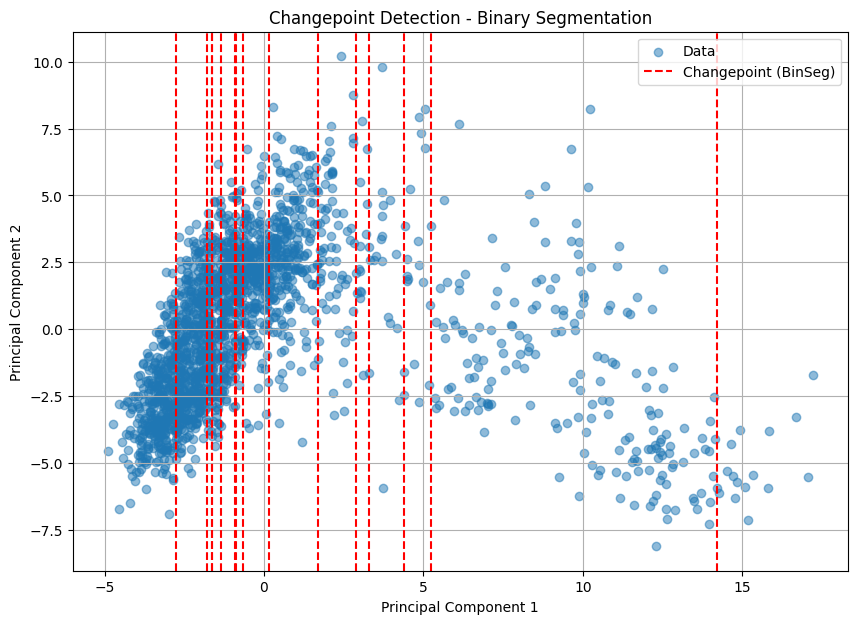

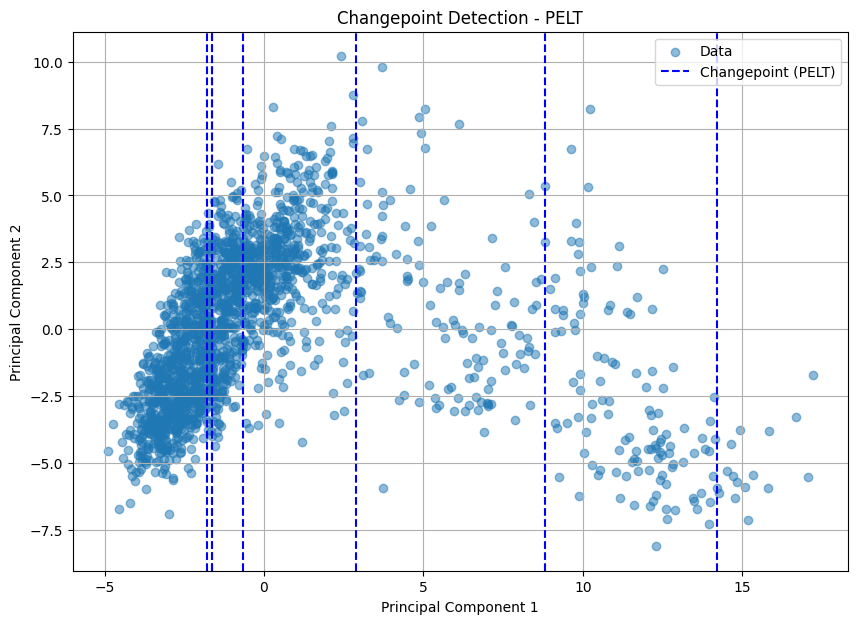

15 Binary Segmentation Breakpoints: [305, 320, 445, 565, 695, 725, 745, 770, 915, 960, 1015, 1435, 1665, 1760, 1835]
7 PELT Breakpoints: [305, 565, 700, 770, 1015, 1435, 1760]


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from sklearn.decomposition import PCA

# Load the data
file_path = '../data/kvasir_capsule/resnet_features.csv' 
data = pd.read_csv(file_path)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Convert reduced data to a DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Apply Binary Segmentation to the reduced data
model_binseg = rpt.Binseg(model="l2").fit(reduced_data)
breakpoints_binseg = model_binseg.predict(n_bkps=15)

# Apply PELT to the reduced data
model_pelt = rpt.Pelt(model="rbf").fit(reduced_data)
breakpoints_pelt = model_pelt.predict(pen=20)

# Ensure breakpoints are within the range of the DataFrame
breakpoints_binseg = [bp for bp in breakpoints_binseg if bp < len(reduced_df)]
breakpoints_pelt = [bp for bp in breakpoints_pelt if bp < len(reduced_df)]

#Plot the results for Binary Segmentation
plt.figure(figsize=(10, 7))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], alpha=0.5, label='Data')
for bp in breakpoints_binseg:
    plt.axvline(x=reduced_df['PC1'].iloc[bp], color='r', linestyle='--', label='Changepoint (BinSeg)' if bp == breakpoints_binseg[0] else "")
plt.title('Changepoint Detection - Binary Segmentation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#Plot the results for PELT
plt.figure(figsize=(10, 7))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], alpha=0.5, label='Data')
for bp in breakpoints_pelt:
    plt.axvline(x=reduced_df['PC1'].iloc[bp], color='b', linestyle='--', label='Changepoint (PELT)' if bp == breakpoints_pelt[0] else "")
plt.title('Changepoint Detection - PELT')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Print breakpoints
print(f"{len(breakpoints_binseg)} Binary Segmentation Breakpoints:", breakpoints_binseg)
print(f"{len(breakpoints_pelt)} PELT Breakpoints:", breakpoints_pelt)

## DAC-NET Cifar-10

In [30]:
import pickle
import torch
import torchvision.transforms.v2 as tv2
import numpy as np
from feature_generator import FeatureGenerator
from model_name import Model
from torchvision import datasets
from torch.utils.data import DataLoader
from typing import Iterable, Union
from PIL import Image
from torch import nn
from torch.optim import Adam, SGD

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class CustomBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CustomBinaryCrossEntropyLoss, self).__init__()

    """_summary_ 
            l_ij is the dot product of two image representations
            r_ij describes whether the two examples belong to the same cluster or not
            v_ij describes whether the image i and j are (dis)similar enough to be considered for training
    """
    def forward(self, l_ij, r_ij, v_ij):
        l_ij = torch.clamp(l_ij, min=1e-7, max=1-1e-7)
        loss = torch.mul((-r_ij * torch.log(l_ij) - (1 - r_ij) * torch.log(1 - l_ij)), v_ij)
        return loss.mean()

class DAC(nn.Module):
    def __init__(self, pretrained=True, batch_size=32, lamb_init=0.0):
        super(DAC, self).__init__()
        self.backbone = FeatureGenerator(Model.RES_NET_18, pretrained).model
        self.batch_size = batch_size
        self.lamb = nn.Parameter(torch.tensor(lamb_init))  
        self.loss_fn = CustomBinaryCrossEntropyLoss()
        self.weight_optimizer = SGD(self.backbone.parameters(), lr=0.01)
        self.lamb_optimizer = SGD([self.lamb], lr=0.009)
        
    def u(self, lamb):
        return 0.95 - lamb
    
    def l(self, lamb):
        return 0.455 + 0.1 * lamb
        
    def cluster(self):
        preprocess = tv2.Compose([
            tv2.Resize(256),
            tv2.CenterCrop(224),
            tv2.ToImage(),
            tv2.ToDtype(torch.float32, scale=True),
            tv2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        cifar10 = datasets.CIFAR10("./datasets", download=True, transform=preprocess)
        
        data_loader = DataLoader(dataset=cifar10, batch_size=self.batch_size, shuffle=True)
        
        for batch_idx, (img_batch, label_batch) in enumerate(data_loader):
            print(f'Processing batch {batch_idx+1}/{len(data_loader)}')
            feature_batch = self._extract_features(img_batch)
            feature_batch = feature_batch.view(feature_batch.size(0), -1)
            
            L = torch.matmul(feature_batch, feature_batch.T)
            R = L.clone()
            V = L.clone()

            """
            TODO: 
            -Check optimization logic, especially for the weight updates
            -Move computations to GPU
            -Reduce sample size
            
            """
            # Matric R: determine similarities 1 means similar 0 means not, None means no statement
            for i in range(L.size(0)):
                for j in range(L.size(1)):
                    l_ij = L[i, j].item()
                    if l_ij >= self.u(self.lamb).item():
                        R[i, j] = 1
                    elif l_ij < self.l(self.lamb).item():
                        R[i, j] = 0
                    else:
                        R[i, j] = None    
                    V[i, j] = 1 if R[i, j] is not None else 0 # Calculate Indicator Parameter -> 0 means not included in training
                        
            self.weight_optimizer.zero_grad()
            for i in range(L.size(0)):
                for j in range(L.size(1)):
                    if R[i, j] is not None:
                        loss = self.loss_fn(L[i, j], R[i, j], V[i, j])
                        loss.backward(retain_graph=True)
            self.weight_optimizer.step()

            # Optimizing lambda
            self.lamb_optimizer.zero_grad()
            loss_lamb = self.u(self.lamb) - self.l(self.lamb)
            loss_lamb.backward()
            self.lamb_optimizer.step()
            
    def _extract_features(self, images) -> torch.Tensor:
        return self._restraint_layer(self.backbone(images))
        
    def _restraint_layer(self, features: torch.Tensor) -> torch.Tensor:
        max_activation = torch.max(features)
        restrained = torch.exp(features - max_activation)  # Mapped into [0,1]
        restrained_normed = restrained / torch.linalg.vector_norm(restrained)  # normed
        return restrained_normed


dac = DAC()
dac.cluster()

Files already downloaded and verified
Processing batch 1/1563


KeyboardInterrupt: 